<a href="https://colab.research.google.com/github/francesco-zatto/dia-project/blob/master/car_emissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os.path
from urllib.request import urlretrieve

DATASETS = {
    "car_emissions_spain2022.csv": "https://raw.githubusercontent.com/pietroolivi/dia-datasets/main/car_emissions_spain2022.csv",
    "car_emissions_canada2014.csv": "https://raw.githubusercontent.com/pietroolivi/dia-datasets/main/car_emissions_canada2014/car_emissions_canada2014.csv",
    "car_emissions_uk2013.csv": "https://raw.githubusercontent.com/pietroolivi/dia-datasets/main/car_emissions_uk2013.csv"
}

for filename, dataset in DATASETS.items():
    if not os.path.exists(filename):
      urlretrieve(dataset, filename)

In [3]:
spain_emissions = pd.read_csv("car_emissions_spain2022.csv")
spain_emissions.head(5)

,id,make,model,market_segment,engine_type,consumption_min_l_100km,consumption_max_l_100km,emissions_min_gCO2_km,emissions_max_gCO2_km,transmission,...,avg_wltp_emissions_gCO2_km,length_mm,width_mm,height_mm,gross_vehicle_weight_rating_kg,total_seating,fuel_economy_index,type_hybrid,electric_consumption_kwh_100km,battery_capacity_kwh
0,551266,AIWAYS,AIWAYS U5 MAS861-WVTA/2WB/FL4,Berlinas-Familiares Medios,Eléctricos puros,NaN,NaN,NaN,NaN,A,...,0.0,4680,1865,1700,2135,5,Sin clasificación,NaN,15.75,63.0
1,579684,AIWAYS,AIWAYS U6 PRIME,Berlinas-Familiares Grandes,Eléctricos puros,NaN,NaN,NaN,NaN,A,...,0.0,4805,1880,1641,2290,5,Sin clasificación,NaN,16.00,63.0
2,464453,ALKE,ALKE ATX 310 E plomo acido,Chasis-Cabina Pequeño,Eléctricos puros,NaN,NaN,NaN,NaN,SC,...,0.0,3030,1500,2000,1510,2,Sin clasificación,NaN,11.00,10.0
3,464454,ALKE,ALKE ATX 320 E plomo acido,Chasis-Cabina Pequeño,Eléctricos puros,NaN,NaN,NaN,NaN,SC,...,0.0,3850,1500,2000,1510,2,Sin clasificación,NaN,11.00,10.0
4,464455,ALKE,ALKE ATX 330 E plomo acido,Chasis-Cabina Pequeño,Eléctricos puros,NaN,NaN,NaN,NaN,SC,...,0.0,3850,1500,2000,1510,2,Sin clasificación,NaN,11.00,10.0


In [4]:
canada_emissions = pd.read_csv("car_emissions_canada2014.csv")
canada_emissions.head(5)

,_id,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km)
0,1,1995,Acura,Integra,Subcompact,1.8,4,A4,X,10.2,7.0,8.8,32,202
1,2,1995,Acura,Integra,Subcompact,1.8,4,M5,X,9.6,7.0,8.4,34,193
2,3,1995,Acura,Integra GS-R,Subcompact,1.8,4,M5,Z,9.4,7.0,8.3,34,191
3,4,1995,Acura,Legend,Compact,3.2,6,A4,Z,12.6,8.9,10.9,26,251
4,5,1995,Acura,Legend Coupe,Compact,3.2,6,A4,Z,13.0,9.3,11.3,25,260


In [5]:
uk_emissions = pd.read_csv("car_emissions_uk2013.csv")
uk_emissions.head(5)

C:\Users\franc\AppData\Local\Temp\ipykernel_7756\3678210660.py:1: DtypeWarning: Columns (6,30) have mixed types. Specify dtype option on import or set low_memory=False.
  uk_emissions = pd.read_csv("car_emissions_uk2013.csv")


,file,year,manufacturer,model,description,euro_standard,tax_band,transmission,transmission_type,engine_capacity,...,nox_emissions,thc_nox_emissions,particulates_emissions,fuel_cost_12000_miles,fuel_cost_6000_miles,standard_12_months,standard_6_months,first_year_12_months,first_year_6_months,date_of_change
0,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,1.6 Twin Spark 16v,2,NaN,M5,Manual,1598.0,...,NaN,NaN,NaN,NaN,618.0,NaN,NaN,NaN,NaN,NaN
1,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,1.8 Twin Spark 16v,2,NaN,M5,Manual,1747.0,...,NaN,NaN,NaN,NaN,633.0,NaN,NaN,NaN,NaN,NaN
2,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,Cloverleaf,2,NaN,M5,Manual,1970.0,...,NaN,NaN,NaN,NaN,663.0,NaN,NaN,NaN,NaN,NaN
3,DatapartC_july2000.csv,2000,Alfa Romeo,146 Range,1.6 Twin Spark 16v,2,NaN,M5,Manual,1598.0,...,NaN,NaN,NaN,NaN,626.0,NaN,NaN,NaN,NaN,NaN
4,DatapartC_july2000.csv,2000,Alfa Romeo,146 Range,1.8 Twin Spark 16v,2,NaN,M5,Manual,1747.0,...,NaN,NaN,NaN,NaN,633.0,NaN,NaN,NaN,NaN,NaN


# **Esplorazione dei singoli dataset**

## Esplorazione del dataset `spain_emissions`

### Rimozione delle righe riguardanti veicoli elettrici

All'interno del dataset proveniente dal ministero spagnolo sono presenti anche dati riguardanti macchine elettriche. Questa tipologia di dato non è interessante per l'obiettivo del modello, ovvero la quantità di CO2 emessa.

La cella seguente analizza i valori delle righe che hanno `engine_type` "Eléctricos puros", estraendo solo le colonne sul minimo e massimo di consumo di litri di carburante e sul minimio e massimo di emissioni di CO2 per km percorso.

In [6]:
columns = ["emissions_min_gCO2_km", "emissions_max_gCO2_km"]
spain_emissions.loc[spain_emissions["engine_type"] == "Eléctricos puros", columns].isna().all()

emissions_min_gCO2_km    True
emissions_max_gCO2_km    True
dtype: bool

Come era previdibile, tutti i valori delle emissioni di CO2 per km nelle righe riguardanti i veicoli elettrici sono mancanti, quindi le rispettive righe possono essere eliminate, poichè non utili per l'addestramento del modello, il cui obiettivo è la previsione dell'emissione di C02 per veicoli a motore termico.

In [7]:
electric_cars_index = spain_emissions.loc[spain_emissions["engine_type"] == "Eléctricos puros"].index
spain_emissions = spain_emissions.drop(electric_cars_index)
spain_emissions["engine_type"].unique()

array(['Gasolina', 'Gasóleo', 'Híbridos enchufables',
       'Híbridos de gasolina', 'Gas natural', 'Híbridos de gasóleo',
       'Gases licuados del petróleo (GLP)', 'Pila de combustible',
       'Autonomía extendida'], dtype=object)

Come si può notare dall'output della cella precedente, la colonna `engine_type` non contiene il valore "Eléctricos puros".

### Traduzione spagnolo-inglese 
Un'altra elaborazione necessaria è una traduzione dallo spagnolo all'inglese sia per questa colonna, che per la colonna della classificazione delle auto, ovvero `market_segment`.

Definisco una funzione per sostituire i valori di una colonna di un dataframe con dei nuovi valori passati come argomento, in questo caso la rispettiva traduzione in inglese, tramite una funzione di mapping fornita da pandas.

In [8]:
def get_column_mapped_values(column, new_values):
    mapping = dict(zip(column.unique(), new_values))
    return column.map(mapping)

In [9]:
#Traduzione della colonna engine_type
spanish_engine_type = spain_emissions["engine_type"].unique()
english_engine_type = ["Petrol", "Diesel", "Plug-in hybrid", "Petrol hybrid", "Natural gas", 
                       "Diesel Hybrid", "Liquefied petroleum gas(LPG)", "Fuel cell", "Extended range"]

spain_emissions["engine_type"] = get_column_mapped_values(spain_emissions["engine_type"], english_engine_type)

Per la traduzione della colonna `market_segment` si fa riferimento al dataset canadese, il quale contiene una colonna per la classificazione dei veicoli, `Vehicle_class`.

In [10]:
canada_emissions["Vehicle class"].unique()

array(['Subcompact', 'Compact', 'Two-seater', 'Station wagon: Small',
       'Minicompact', 'Mid-size', 'Full-size', 'Station wagon: Mid-size',
       'Van: Cargo', 'Van: Passenger', 'Pickup truck: Standard',
       'Sport utility vehicle', 'Minivan', 'Pickup truck: Small',
       'Special purpose vehicle', 'Sport utility vehicle: Small',
       'Sport utility vehicle: Standard'], dtype=object)

In [11]:
#Traduzione della colonna market_segment
english_market_segment = ["Minicompact", "Compact", "Small off-road", "Mid-size", "Sport utility vehicle", "Full-size", 
                          "Mid-size off-road", "Full-size off-road", "Minivan", "Luxury", "Minivan", "Van: Passenger"] \
                        + (["Van: Cargo"] * 2) + (["Lorry"] * 7)

spain_emissions["market_segment"] = get_column_mapped_values(spain_emissions["market_segment"], english_market_segment)

### Calcolo del volume del motore in cm<sup>3</sup>
Il dataset contiene tre colonne che rispettivamente indicano le tre dimensioni del motore, ovvero lunghezza, larghezza e altezza in millimetri. Queste tre colonne potrebbero essere delle feature molto importanti per il modello. Quindi è necessario mantenerle nel dataset per motivi di compatibilità con gli altri dataset in una nuova colonna `engine_capacity_cm3`, il volume in centimetri cubi, dato dal prodotto delle tre colonne e convertito successivamente in cm<sup>3</sup>.


In [12]:
spain_emissions["engine_capacity_cm3"] = spain_emissions["length_mm"] * spain_emissions["width_mm"] * spain_emissions["height_mm"]
spain_emissions["engine_capacity_cm3"] /= 1000

### Rimozione delle colonne contenenti solo valori `NaN`
Nel dataset dell'emissioni di CO<sub>2</sub> proveniente dalla Spagna la colonne `type_hybrid`, `electric_consumption_kwh_100km`, `battery_capacity_kwh ` contengono solo valori `NaN`.

In [13]:
all_nan_columns = ["type_hybrid", "electric_consumption_kwh_100km", "battery_capacity_kwh"]
spain_emissions[all_nan_columns].isna().values.all()

True

Quindi possono essere rimosse dal dataset, poiché non sono feature interessanti ed utili per l'addestramento del modello.

In [14]:
spain_emissions = spain_emissions.drop(all_nan_columns, axis=1)

### Grafici 
Questa sezione contiene alcuni grafici che evidenziano alcuni aspetti del dataframe risulante `spain_emissions`.

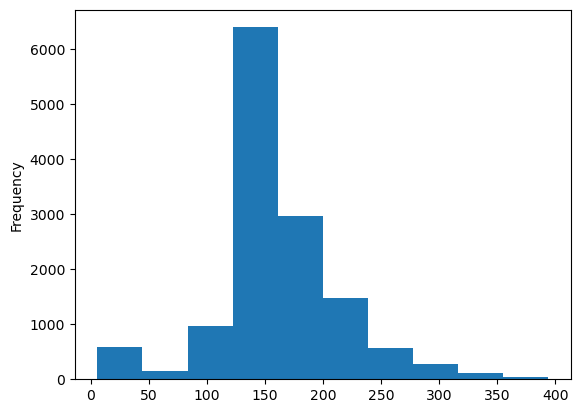

In [23]:
spain_emissions["emissions_max_gCO2_km"].plot.hist();

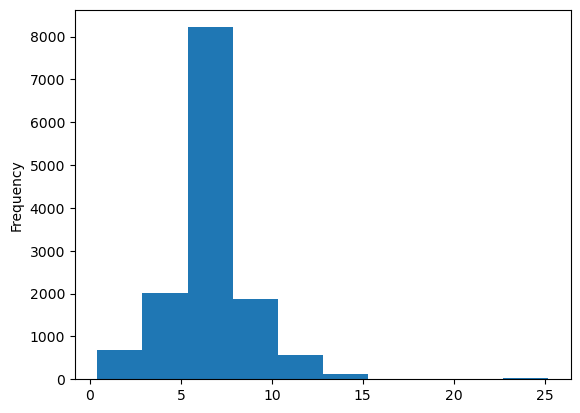

In [24]:
spain_emissions["consumption_max_l_100km"].plot.hist();

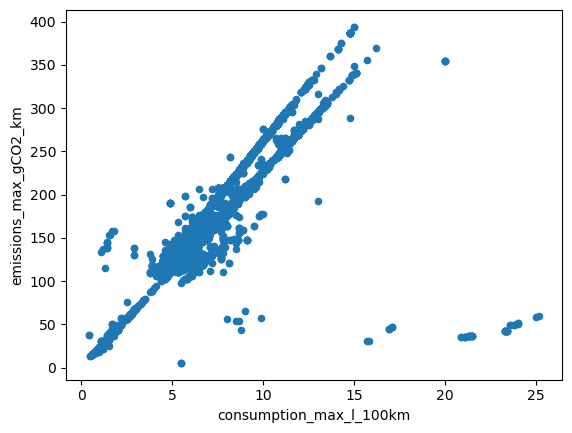

In [27]:
spain_emissions.plot.scatter("consumption_max_l_100km", "emissions_max_gCO2_km");

# **Omogeneizzazione ed unione dei dati**
Avendo reperito tre set di dati ciascuno da una fonte differente, sebbene questi concernano il medesimo dominio e condividano pertanto una considerevole quantità di attributi,

Potremmo essere erroneamente portati a compiere un troncamento delle colonne, conservando esclusivamente quelle appartenenti all'intersezione delle tre tabelle, tuttavia così facendo andremmo a trascurare il caso-limite in cui le features eliminate dovessero essere le uniche legate, attraverso un relazione non randomica, a quella indagata. Una soluzione più scrupolosa consisterebbe, al contrario, nell'unione degli attributi, colmando opportunamente le celle vuote formatesi. In effetti, come visto a lezione, i valori NAN possono essere sostituiti, tra gli altri, da:
- media
- moda
- mediana

In aggiunta, le stesse variabili in comune, malgrado facciano riferimento allo stesso concetto, si manifestano talvolta sotto denominazioni diverse, ed a loro volta i valori corrispondenti da queste assunti potrebbero avere formato dissimile (e.g. capitalizzazione delle lettere nel caso testuale o numero di cifre significative in quello numerico).





